Let's first do some preprocessing to our dataset

In [1]:
from PIL import Image

In [2]:
import os
f=open(r'C:/Users/Hou Peizhe/Documents/Dataset/A.txt',"a")
for root,dirs,files in os.walk(r'C:/Users/Hou Peizhe/Documents/Dataset/train/A/'):
    for file in files:
        f.writelines(os.path.join(root,file)+"\n") 
f.close()

In [3]:
import os
f=open(r'C:/Users/Hou Peizhe/Documents/Dataset/B.txt',"a")
for root,dirs,files in os.walk(r'C:/Users/Hou Peizhe/Documents/Dataset/train/B/'):
    for file in files:
        f.writelines(os.path.join(root,file)+"\n") 
f.close()

In [ ]:
for i, img in enumerate(a):
    img=img[:-1]
    im = Image.open(img,"r").convert(mode='RGB')
    im=im.resize(size=(256,256))
    img=img.split("/")
    path=""
    for index, folder in enumerate(img):
        if index!=len(img)-1:
            path+=folder
            path+="/"
    path+=str(i)
    path+=".jpg"
    im.save("./A/"+str(i)+".jpg")

In [93]:
for i, img in enumerate(b):
    img=img[:-1]
    im = Image.open(img,"r").convert(mode="RGB")
    im=im.resize(size=(256,256))
    img=img.split("/")
    path=""
    for index, folder in enumerate(img):
        if index!=len(img)-1:
            path+=folder
            path+="/"
    path+=str(i)
    path+=".jpg"
#     im.save(path)
    im.save("./B/"+str(i)+".jpg")

Then define the model for our CycleGAN

In [1]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

In [7]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

Some utilities

In [2]:
import glob
import random
import os

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '%s/A' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%s/B' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [3]:
import random
import time
import datetime
import sys

from torch.autograd import Variable
import torch
from visdom import Visdom
import numpy as np

def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)

class Logger():
    def __init__(self, n_epochs, batches_epoch):
        self.viz = Visdom()
        self.n_epochs = n_epochs
        self.batches_epoch = batches_epoch
        self.epoch = 1
        self.batch = 1
        self.prev_time = time.time()
        self.mean_period = 0
        self.losses = {}
        self.loss_windows = {}
        self.image_windows = {}


    def log(self, losses=None, images=None):
        self.mean_period += (time.time() - self.prev_time)
        self.prev_time = time.time()

        sys.stdout.write('\rEpoch %03d/%03d [%04d/%04d] -- ' % (self.epoch, self.n_epochs, self.batch, self.batches_epoch))

        for i, loss_name in enumerate(losses.keys()):
            if loss_name not in self.losses:
#                 self.losses[loss_name] = losses[loss_name].data[0]
                self.losses[loss_name] = losses[loss_name].item()
            else:
#                 self.losses[loss_name] += losses[loss_name].data[0]
                self.losses[loss_name] += losses[loss_name].item()

            if (i+1) == len(losses.keys()):
                sys.stdout.write('%s: %.4f -- ' % (loss_name, self.losses[loss_name]/self.batch))
            else:
                sys.stdout.write('%s: %.4f | ' % (loss_name, self.losses[loss_name]/self.batch))

        batches_done = self.batches_epoch*(self.epoch - 1) + self.batch
        batches_left = self.batches_epoch*(self.n_epochs - self.epoch) + self.batches_epoch - self.batch 
        sys.stdout.write('ETA: %s' % (datetime.timedelta(seconds=batches_left*self.mean_period/batches_done)))

        # Draw images
        for image_name, tensor in images.items():
            if image_name not in self.image_windows:
                self.image_windows[image_name] = self.viz.image(tensor2image(tensor.data), opts={'title':image_name})
            else:
                self.viz.image(tensor2image(tensor.data), win=self.image_windows[image_name], opts={'title':image_name})

        # End of epoch
        if (self.batch % self.batches_epoch) == 0:
            # Plot losses
            for loss_name, loss in self.losses.items():
                if loss_name not in self.loss_windows:
                    self.loss_windows[loss_name] = self.viz.line(X=np.array([self.epoch]), Y=np.array([loss/self.batch]), 
                                                                    opts={'xlabel': 'epochs', 'ylabel': loss_name, 'title': loss_name})
                else:
                    self.viz.line(X=np.array([self.epoch]), Y=np.array([loss/self.batch]), win=self.loss_windows[loss_name], update='append')
                # Reset losses for next epoch
                self.losses[loss_name] = 0.0

            self.epoch += 1
            self.batch = 1
            sys.stdout.write('\n')
        else:
            self.batch += 1

        

class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

Do the training finally. 

In [10]:
## hyperparameters
epoch=0 #starting epoch
n_epochs=100   #number of epochs of training
batchSize=2   #size of the batches
dataroot=r'C:/Users/Hou Peizhe/Documents/Dataset/' #root directory of the dataset
lr=0.0002            #initial learning rate
decay_epoch=50                    #epoch to start linearly decaying the learning rate to 0
size=256                  #size of the data crop (squared assumed)
input_nc=3              #number of channels of input data
output_nc=3                #number of channels of output data
cuda=False
n_cpu=1               #number of cpu threads to use during batch generation

In [11]:
import argparse
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch

# from models import Generator
# from models import Discriminator
# from utils import ReplayBuffer
# from utils import LambdaLR
# from utils import Logger
# from utils import weights_init_normal
# from datasets import ImageDataset

# parser = argparse.ArgumentParser()
# parser.add_argument('--epoch', type=int, default=0, help='starting epoch')
# parser.add_argument('--n_epochs', type=int, default=200, help='number of epochs of training')
# parser.add_argument('--batchSize', type=int, default=1, help='size of the batches')
# parser.add_argument('--dataroot', type=str, default='datasets/horse2zebra/', help='root directory of the dataset')
# parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate')
# parser.add_argument('--decay_epoch', type=int, default=100, help='epoch to start linearly decaying the learning rate to 0')
# parser.add_argument('--size', type=int, default=256, help='size of the data crop (squared assumed)')
# parser.add_argument('--input_nc', type=int, default=3, help='number of channels of input data')
# parser.add_argument('--output_nc', type=int, default=3, help='number of channels of output data')
# parser.add_argument('--cuda', action='store_true', help='use GPU computation')
# parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')
# opt = parser.parse_args([])
# print(opt)

if torch.cuda.is_available() and not cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    


###### Definition of variables ######
# Networks
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)

if cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
input_A = Tensor(batchSize, input_nc, size, size)
input_B = Tensor(batchSize, output_nc, size, size)
target_real = Variable(Tensor(batchSize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batchSize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()
# Dataset loader
transforms_ = [ transforms.Resize(int(size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(dataroot, transforms_=transforms_, unaligned=True), 
                        batch_size=batchSize, shuffle=True)

# Loss plot
logger = Logger(n_epochs, len(dataloader))
###################################



/home/mingjie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
Setting up a new session...


In [14]:
###### Training ######
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################

        # Progress report (http://localhost:8097)
        logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
                    'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
                    images={'real_A': real_A, 'real_B': real_B, 'fake_A': fake_A, 'fake_B': fake_B})

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), dataroot+'/output/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), dataroot+'/output/netG_B2A.pth')
    torch.save(netD_A.state_dict(), dataroot+'/output/netD_A.pth')
    torch.save(netD_B.state_dict(), dataroot+'/output/netD_B.pth')

Epoch 003/100 [0051/0051] -- loss_G: 5.8419 | loss_G_identity: 1.6338 | loss_G_GAN: 0.6634 | loss_G_cycle: 3.5446 | loss_D: 0.4006 -- ETA: 17:43:00.057802
Epoch 004/100 [0051/0051] -- loss_G: 5.5702 | loss_G_identity: 1.4885 | loss_G_GAN: 0.8545 | loss_G_cycle: 3.2271 | loss_D: 0.3815 -- ETA: 16:25:10.257980
Epoch 005/100 [0051/0051] -- loss_G: 5.1438 | loss_G_identity: 1.4012 | loss_G_GAN: 0.6899 | loss_G_cycle: 3.0527 | loss_D: 0.4208 -- ETA: 15:34:56.264795
Epoch 006/100 [0051/0051] -- loss_G: 5.4370 | loss_G_identity: 1.4280 | loss_G_GAN: 0.9341 | loss_G_cycle: 3.0749 | loss_D: 0.3703 -- ETA: 14:59:04.952379
Epoch 007/100 [0051/0051] -- loss_G: 5.1292 | loss_G_identity: 1.3541 | loss_G_GAN: 0.8712 | loss_G_cycle: 2.9039 | loss_D: 0.3844 -- ETA: 14:30:54.151554
Epoch 008/100 [0051/0051] -- loss_G: 5.0373 | loss_G_identity: 1.3346 | loss_G_GAN: 0.7928 | loss_G_cycle: 2.9098 | loss_D: 0.3759 -- ETA: 14:07:50.016175
Epoch 009/100 [0051/0051] -- loss_G: 4.7687 | loss_G_identity: 1.2646 

In [12]:
## generate more results
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)
netG_A2B.load_state_dict(torch.load('/output/netG_A2B.pth'))
netG_B2A.load_state_dict(torch.load('/output/netG_B2A.pth'))
netD_A.load_state_dict(torch.load('/output/netD_A.pth'))
netD_B.load_state_dict(torch.load('/output/netD_B.pth'))
netG_A2B.eval()
netG_B2A.eval()
netD_A.eval()
netD_B.eval()

<All keys matched successfully>

In [21]:
netG_A2B.eval()
netG_B2A.eval()
netD_A.eval()
netD_B.eval()

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

Try with my own sketches!

(-0.5, 255.5, 255.5, -0.5)

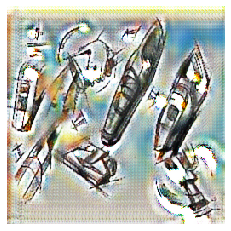

In [43]:
import matplotlib.pyplot as plt
transforms_ = [ transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
transform = transforms.Compose(transforms_)
img1 = Image.open(r'C:/Users/Hou Peizhe/Desktop/101.png',"r").convert(mode='RGB')
img1 = img1.resize(size=(256,256))
img1 = transform(img1)
img1 = img1.unsqueeze(0)
fake_img1 = netG_A2B(img1)
fake_img1 = tensor2image(fake_img1.data)
plt.imshow(fake_img1.transpose(1,2,0))
plt.axis("off")

(-0.5, 1042.5, 857.5, -0.5)

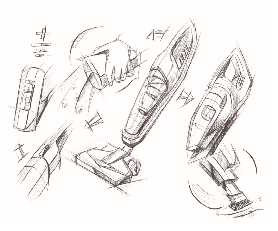

In [44]:
plt.imshow(Image.open(r'C:/Users/Hou Peizhe/Desktop/101.png',"r").convert(mode='RGB'))
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

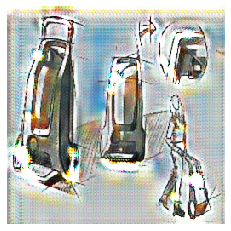

In [45]:
img2 = Image.open(r'C:/Users/Hou Peizhe/Desktop/102.png',"r").convert(mode='RGB')
img2 = img2.resize(size=(256,256))
img2 = transform(img2)
img2 = img2.unsqueeze(0)
fake_img2 = netG_A2B(img2)
fake_img2 = tensor2image(fake_img2.data)
plt.imshow(fake_img2.transpose(1,2,0))
plt.axis("off")

(-0.5, 965.5, 716.5, -0.5)

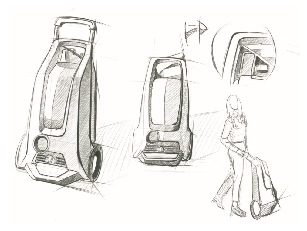

In [46]:
plt.imshow(Image.open(r'C:/Users/Hou Peizhe/Desktop/102.png',"r").convert(mode='RGB'))
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

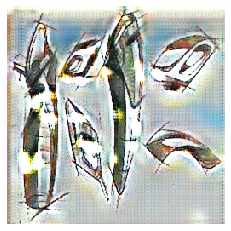

In [47]:
img3 = Image.open(r'C:/Users/Hou Peizhe/Desktop/103.png',"r").convert(mode='RGB')
img3 = img3.resize(size=(256,256))
img3 = transform(img3)
img3 = img3.unsqueeze(0)
fake_img3 = netG_A2B(img3)
fake_img3 = tensor2image(fake_img3.data)
plt.imshow(fake_img3.transpose(1,2,0))
plt.axis("off")

(-0.5, 1212.5, 739.5, -0.5)

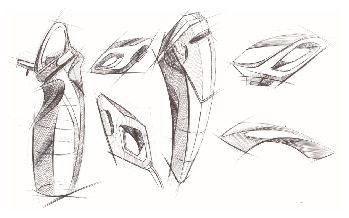

In [48]:
plt.imshow(Image.open(r'C:/Users/Hou Peizhe/Desktop/103.png',"r").convert(mode='RGB'))
plt.axis("off")